In [1]:
import pickle
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import timeit
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization
import tensorflow_model_optimization as tfmot
from tensorflow.keras.models import load_model
import os
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

2023-06-06 00:10:00.242956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 00:10:00.377042: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-06 00:10:00.732795: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/themandalorian/anaconda3/envs/ml-on-mc/lib/
2023-06-06 00:10:00.732851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: lib

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load the CIFAR-10 dataset
data_path = 'cifar-10-batches-py/'
train_data = []
train_labels = []
for i in range(1, 6):
    batch = unpickle(data_path + 'data_batch_' + str(i))
    train_data.append(batch[b'data'])
    train_labels += batch[b'labels']
    
    
train_data = np.concatenate(train_data)
train_data = train_data.reshape((50000, 3, 32, 32)).transpose(0, 2, 3, 1)
test_data = unpickle(data_path + 'test_batch')[b'data']
test_data = test_data.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)
train_labels = np.array(train_labels)
test_labels = np.array(unpickle(data_path + 'test_batch')[b'labels'])

# Print the number of features, classes, and training samples for CIFAR-10
print("CIFAR-10")
print("Number of features:", train_data.shape[1:])
print("Number of classes:", len(np.unique(train_labels)))
print("Number of training samples:", train_data.shape[0])

# Shuffle your dataset
train_data, train_labels = shuffle(train_data, train_labels, random_state=42)
test_data, test_labels = shuffle(test_data, test_labels, random_state=42)

# Normalize pixel values
x_train = train_data.astype('float32') / 255.0
x_test = test_data.astype('float32') / 255.0

# Convert labels to categorical format
y_train = to_categorical(train_labels, num_classes=10)
y_test = to_categorical(test_labels, num_classes=10)

# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train = datagen.flow(x_train, y_train, batch_size=64)
# fit model
steps = int(x_train.shape[0] / 64)

CIFAR-10
Number of features: (32, 32, 3)
Number of classes: 10
Number of training samples: 50000


In [3]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

    c_str = ''

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'

    # Add array length at top of file
    c_str += '\nstatic const unsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

    # Declare C variable
    c_str += 'static const unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data) :

        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str

In [4]:
# plot the confusion matrix for the quantized model
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

"""
function: plot_confusion_matrix
    - input: cm, classes, normalize, title, cmap
    - output: none
    - description: plots the confusion matrix
"""

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Print the model summary
model.summary()

2023-06-05 20:00:43.861454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 20:00:43.861785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 20:00:43.862020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 20:00:43.862497: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 20:00:43.862747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
model_10 = Sequential()
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.1))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# define the ModelCheckpoint callback to save the model after each epoch
checkpoint_callback = ModelCheckpoint(filepath='model_10_VGG16_Base.h5', save_freq='epoch')

# compile model
opt = SGD(lr=0.001, momentum=0.9)
model_10.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train and evaluate the quantization aware model
model_10.fit(it_train, steps_per_epoch=steps, epochs=400,
                      validation_data=(x_test, y_test), callbacks=[checkpoint_callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      

781/781 [==============================] - 14s 17ms/step - loss: 0.5326 - accuracy: 0.8206 - val_loss: 0.4920 - val_accuracy: 0.8359
Epoch 84/400
781/781 [==============================] - 14s 18ms/step - loss: 0.5228 - accuracy: 0.8268 - val_loss: 0.5292 - val_accuracy: 0.8332
Epoch 85/400
781/781 [==============================] - 14s 18ms/step - loss: 0.5189 - accuracy: 0.8276 - val_loss: 0.5717 - val_accuracy: 0.8207
Epoch 86/400
781/781 [==============================] - 14s 17ms/step - loss: 0.5196 - accuracy: 0.8278 - val_loss: 0.5831 - val_accuracy: 0.8173
Epoch 87/400
781/781 [==============================] - 14s 18ms/step - loss: 0.5137 - accuracy: 0.8273 - val_loss: 0.5039 - val_accuracy: 0.8369
Epoch 88/400
781/781 [==============================] - 14s 18ms/step - loss: 0.5142 - accuracy: 0.8290 - val_loss: 0.5333 - val_accuracy: 0.8260
Epoch 89/400
781/781 [==============================] - 15s 19ms/step - loss: 0.5070 - accuracy: 0.8301 - val_loss: 0.4875 - val_accuracy

Epoch 139/400
781/781 [==============================] - 15s 19ms/step - loss: 0.3864 - accuracy: 0.8707 - val_loss: 0.4508 - val_accuracy: 0.8590
Epoch 140/400
781/781 [==============================] - 15s 20ms/step - loss: 0.3802 - accuracy: 0.8733 - val_loss: 0.4577 - val_accuracy: 0.8570
Epoch 141/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3830 - accuracy: 0.8716 - val_loss: 0.4593 - val_accuracy: 0.8575
Epoch 142/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3797 - accuracy: 0.8737 - val_loss: 0.4739 - val_accuracy: 0.8534
Epoch 143/400
781/781 [==============================] - 15s 19ms/step - loss: 0.3799 - accuracy: 0.8727 - val_loss: 0.4704 - val_accuracy: 0.8534
Epoch 144/400
781/781 [==============================] - 15s 19ms/step - loss: 0.3785 - accuracy: 0.8731 - val_loss: 0.4496 - val_accuracy: 0.8583
Epoch 145/400
781/781 [==============================] - 14s 17ms/step - loss: 0.3753 - accuracy: 0.8746 - val_loss: 0

Epoch 195/400
781/781 [==============================] - 15s 19ms/step - loss: 0.3018 - accuracy: 0.8984 - val_loss: 0.4745 - val_accuracy: 0.8620
Epoch 196/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3087 - accuracy: 0.8968 - val_loss: 0.4101 - val_accuracy: 0.8734
Epoch 197/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3061 - accuracy: 0.8966 - val_loss: 0.4315 - val_accuracy: 0.8675
Epoch 198/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3042 - accuracy: 0.8978 - val_loss: 0.4589 - val_accuracy: 0.8651
Epoch 199/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3088 - accuracy: 0.8965 - val_loss: 0.3991 - val_accuracy: 0.8771
Epoch 200/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3038 - accuracy: 0.8975 - val_loss: 0.4501 - val_accuracy: 0.8668
Epoch 201/400
781/781 [==============================] - 15s 19ms/step - loss: 0.2956 - accuracy: 0.9002 - val_loss: 0

In [5]:
# load the pre-saved model
model_10 = load_model('model_10_VGG16_Base.h5')

# test the accuracy of the model on the test set
loss, accuracy = model_10.evaluate(x_test, y_test)

# print the accuracy of the model on the test set
print('model_10_VGG16_Base.h5 Test accuracy:', accuracy)

2023-06-05 20:00:55.505560: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


 40/313 [==>...........................] - ETA: 1s - loss: 0.5058 - accuracy: 0.8570

2023-06-05 20:00:56.657545: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - 3s 4ms/step - loss: 0.4530 - accuracy: 0.8814
model_10_VGG16_Base.h5 Test accuracy: 0.8813999891281128


313/313 [==============================] - 1s 3ms/step
Confusion matrix, without normalization
[[933  11   7   5   3   2   2   2  25  10]
 [  3 972   0   0   0   1   1   0   3  20]
 [ 44   5 800  17  26  44  48   9   6   1]
 [ 17   8  25 683  30 145  59  16  11   6]
 [ 11   1  26  12 864  21  35  25   3   2]
 [  5   4  10  64  16 862  20  14   1   4]
 [  5   2  16  11   5   8 948   2   1   2]
 [  8   0  10   7  20  27   3 920   1   4]
 [ 37  20   3   2   1   1   3   2 921  10]
 [ 13  58   2   1   2   1   3   0   9 911]]


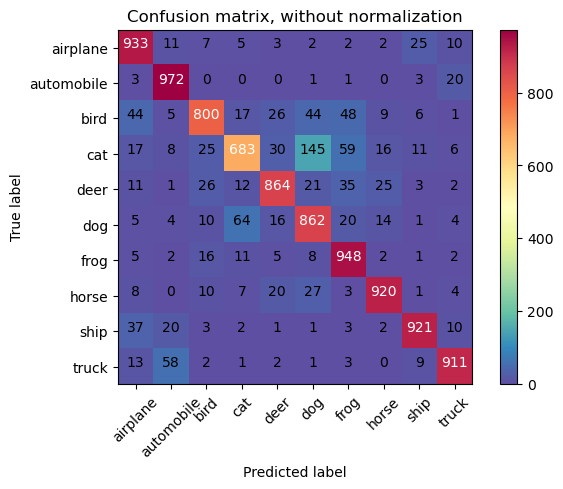

In [7]:
# Make predictions
y_pred = model_10.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [14]:
model_10 = Sequential()
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_10.add(BatchNormalization())
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(BatchNormalization())
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(BatchNormalization())
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(BatchNormalization())
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(BatchNormalization())
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(BatchNormalization())
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(BatchNormalization())
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# define the ModelCheckpoint callback to save the model after each epoch
checkpoint_callback = ModelCheckpoint(filepath='model_10_VGG8_Base.h5', save_freq='epoch')

# compile model
opt = SGD(lr=0.001, momentum=0.9)
model_10.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train and evaluate the quantization aware model
model_10.fit(it_train, steps_per_epoch=steps, epochs=400,
                      validation_data=(x_test, y_test), callbacks=[checkpoint_callback])

313/313 [==============================] - 1s 2ms/step - loss: 0.3419 - accuracy: 0.8904
model_10_VGG8_Base.h5 Test accuracy: 0.8903999924659729
313/313 [==============================] - 1s 2ms/step
Confusion matrix, without normalization
[[882   5  20   4   9   0   5   5  55  15]
 [  2 958   0   0   0   2   2   0   5  31]
 [ 30   1 847  18  32  21  39   5   3   4]
 [ 12   2  24 757  34  78  51  17  14  11]
 [  4   1  23  20 894   9  32  16   1   0]
 [  6   3  20  90  30 814  15  15   6   1]
 [  5   1  15  16   7   2 947   2   2   3]
 [  8   2  11  16  27  15   8 905   3   5]
 [ 22   4   2   3   0   0   1   0 956  12]
 [ 13  31   1   0   1   1   1   1   7 944]]


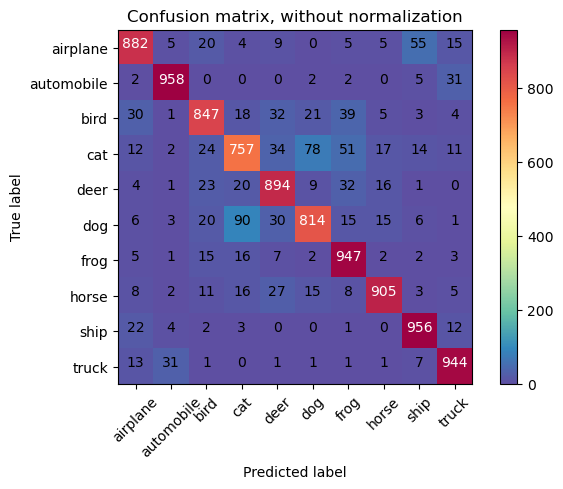

In [8]:
# load the pre-saved model
model_10 = load_model('model_10_VGG8_Base.h5')

# test the accuracy of the model on the test set
loss, accuracy = model_10.evaluate(x_test, y_test)

# print the accuracy of the model on the test set
print('model_10_VGG8_Base.h5 Test accuracy:', accuracy)

# Make predictions
y_pred = model_10.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [84]:
model_10 = Sequential()
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Dropout(0.1))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# define the ModelCheckpoint callback to save the model after each epoch
checkpoint_callback = ModelCheckpoint(filepath='model_10_VGG15_Base.h5', save_freq='epoch')

# compile model
opt = SGD(lr=0.001, momentum=0.9)
model_10.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train and evaluate the quantization aware model
model_10.fit(it_train, steps_per_epoch=steps, epochs=400,
                      validation_data=(x_test, y_test), callbacks=[checkpoint_callback])

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_920 (Conv2D)         (None, 32, 32, 16)        448       
                                                                 
 conv2d_921 (Conv2D)         (None, 32, 32, 16)        2320      
                                                                 
 dropout_445 (Dropout)       (None, 32, 32, 16)        0         
                                                                 
 conv2d_922 (Conv2D)         (None, 32, 32, 32)        4640      
                                                                 
 conv2d_923 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_344 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                     

Epoch 29/400
781/781 [==============================] - 13s 17ms/step - loss: 1.0970 - accuracy: 0.6121 - val_loss: 0.9757 - val_accuracy: 0.6560
Epoch 30/400
781/781 [==============================] - 14s 18ms/step - loss: 1.0917 - accuracy: 0.6149 - val_loss: 1.0225 - val_accuracy: 0.6387
Epoch 31/400
781/781 [==============================] - 13s 17ms/step - loss: 1.0689 - accuracy: 0.6222 - val_loss: 0.9568 - val_accuracy: 0.6593
Epoch 32/400
781/781 [==============================] - 14s 18ms/step - loss: 1.0508 - accuracy: 0.6315 - val_loss: 1.0037 - val_accuracy: 0.6516
Epoch 33/400
781/781 [==============================] - 14s 18ms/step - loss: 1.0307 - accuracy: 0.6373 - val_loss: 0.9762 - val_accuracy: 0.6539
Epoch 34/400
781/781 [==============================] - 14s 18ms/step - loss: 1.0221 - accuracy: 0.6423 - val_loss: 0.9526 - val_accuracy: 0.6615
Epoch 35/400
781/781 [==============================] - 14s 18ms/step - loss: 1.0131 - accuracy: 0.6447 - val_loss: 0.9464 -

Epoch 141/400
781/781 [==============================] - 14s 18ms/step - loss: 0.4762 - accuracy: 0.8404 - val_loss: 0.4657 - val_accuracy: 0.8459
Epoch 142/400
781/781 [==============================] - 14s 18ms/step - loss: 0.4735 - accuracy: 0.8402 - val_loss: 0.4763 - val_accuracy: 0.8463
Epoch 143/400
781/781 [==============================] - 14s 18ms/step - loss: 0.4670 - accuracy: 0.8448 - val_loss: 0.4441 - val_accuracy: 0.8518
Epoch 144/400
781/781 [==============================] - 14s 18ms/step - loss: 0.4690 - accuracy: 0.8447 - val_loss: 0.4749 - val_accuracy: 0.8460
Epoch 145/400
781/781 [==============================] - 13s 17ms/step - loss: 0.4635 - accuracy: 0.8459 - val_loss: 0.5052 - val_accuracy: 0.8389
Epoch 146/400
781/781 [==============================] - 14s 18ms/step - loss: 0.4695 - accuracy: 0.8438 - val_loss: 0.4644 - val_accuracy: 0.8511
Epoch 147/400
781/781 [==============================] - 14s 17ms/step - loss: 0.4683 - accuracy: 0.8462 - val_loss: 0

Epoch 197/400
781/781 [==============================] - 14s 17ms/step - loss: 0.3898 - accuracy: 0.8689 - val_loss: 0.4188 - val_accuracy: 0.8657
Epoch 198/400
781/781 [==============================] - 13s 17ms/step - loss: 0.3818 - accuracy: 0.8728 - val_loss: 0.4468 - val_accuracy: 0.8588
Epoch 199/400
781/781 [==============================] - 13s 17ms/step - loss: 0.3818 - accuracy: 0.8712 - val_loss: 0.4136 - val_accuracy: 0.8656
Epoch 200/400
781/781 [==============================] - 13s 16ms/step - loss: 0.3858 - accuracy: 0.8714 - val_loss: 0.4492 - val_accuracy: 0.8589
Epoch 201/400
781/781 [==============================] - 14s 17ms/step - loss: 0.3797 - accuracy: 0.8722 - val_loss: 0.4156 - val_accuracy: 0.8654
Epoch 202/400
781/781 [==============================] - 14s 17ms/step - loss: 0.3811 - accuracy: 0.8707 - val_loss: 0.4227 - val_accuracy: 0.8636
Epoch 203/400
781/781 [==============================] - 13s 17ms/step - loss: 0.3817 - accuracy: 0.8728 - val_loss: 0

Epoch 253/400
781/781 [==============================] - 13s 16ms/step - loss: 0.3312 - accuracy: 0.8876 - val_loss: 0.4025 - val_accuracy: 0.8728
Epoch 254/400
781/781 [==============================] - 13s 17ms/step - loss: 0.3279 - accuracy: 0.8899 - val_loss: 0.3937 - val_accuracy: 0.8790
Epoch 255/400
781/781 [==============================] - 13s 17ms/step - loss: 0.3267 - accuracy: 0.8897 - val_loss: 0.4135 - val_accuracy: 0.8696
Epoch 256/400
781/781 [==============================] - 13s 17ms/step - loss: 0.3230 - accuracy: 0.8909 - val_loss: 0.4020 - val_accuracy: 0.8731
Epoch 257/400
781/781 [==============================] - 13s 17ms/step - loss: 0.3217 - accuracy: 0.8935 - val_loss: 0.4182 - val_accuracy: 0.8695
Epoch 258/400
781/781 [==============================] - 13s 17ms/step - loss: 0.3244 - accuracy: 0.8915 - val_loss: 0.4113 - val_accuracy: 0.8697
Epoch 259/400
781/781 [==============================] - 13s 17ms/step - loss: 0.3230 - accuracy: 0.8917 - val_loss: 0

Epoch 309/400
781/781 [==============================] - 13s 17ms/step - loss: 0.2872 - accuracy: 0.9026 - val_loss: 0.4052 - val_accuracy: 0.8749
Epoch 310/400
781/781 [==============================] - 13s 16ms/step - loss: 0.2918 - accuracy: 0.9010 - val_loss: 0.4164 - val_accuracy: 0.8747
Epoch 311/400
781/781 [==============================] - 13s 17ms/step - loss: 0.2876 - accuracy: 0.9026 - val_loss: 0.4139 - val_accuracy: 0.8734
Epoch 312/400
781/781 [==============================] - 14s 18ms/step - loss: 0.2856 - accuracy: 0.9039 - val_loss: 0.3872 - val_accuracy: 0.8814
Epoch 313/400
781/781 [==============================] - 13s 17ms/step - loss: 0.2833 - accuracy: 0.9044 - val_loss: 0.4088 - val_accuracy: 0.8723
Epoch 314/400
781/781 [==============================] - 13s 17ms/step - loss: 0.2878 - accuracy: 0.9021 - val_loss: 0.3990 - val_accuracy: 0.8739
Epoch 315/400
781/781 [==============================] - 13s 17ms/step - loss: 0.2877 - accuracy: 0.9022 - val_loss: 0

Epoch 365/400
781/781 [==============================] - 13s 17ms/step - loss: 0.2605 - accuracy: 0.9116 - val_loss: 0.3616 - val_accuracy: 0.8881
Epoch 366/400
781/781 [==============================] - 13s 17ms/step - loss: 0.2588 - accuracy: 0.9123 - val_loss: 0.3856 - val_accuracy: 0.8802
Epoch 367/400
781/781 [==============================] - 14s 18ms/step - loss: 0.2542 - accuracy: 0.9139 - val_loss: 0.3739 - val_accuracy: 0.8855
Epoch 368/400
781/781 [==============================] - 14s 18ms/step - loss: 0.2541 - accuracy: 0.9151 - val_loss: 0.3499 - val_accuracy: 0.8939
Epoch 369/400
781/781 [==============================] - 13s 16ms/step - loss: 0.2553 - accuracy: 0.9132 - val_loss: 0.3762 - val_accuracy: 0.8862
Epoch 370/400
781/781 [==============================] - 13s 17ms/step - loss: 0.2568 - accuracy: 0.9140 - val_loss: 0.3663 - val_accuracy: 0.8879
Epoch 371/400
781/781 [==============================] - 13s 17ms/step - loss: 0.2540 - accuracy: 0.9140 - val_loss: 0

313/313 [==============================] - 1s 3ms/step - loss: 0.3522 - accuracy: 0.8942
model_10_VGG15_Base.h5 Test accuracy: 0.8942000269889832
313/313 [==============================] - 1s 2ms/step
Confusion matrix, without normalization
[[901   6  22   3   9   0   7   3  38  11]
 [  3 970   1   1   0   0   0   0   6  19]
 [ 22   2 844  17  32  20  44  14   2   3]
 [ 10   2  41 747  32  76  57  20   4  11]
 [  6   2  22  16 891   6  32  24   0   1]
 [  6   1  21  82  33 806  17  30   0   4]
 [  3   1   9  15   7   2 958   2   2   1]
 [  8   0   6   9  22  10   5 938   1   1]
 [ 16   8   4   5   4   1   3   1 944  14]
 [  4  39   1   2   1   0   3   1   6 943]]


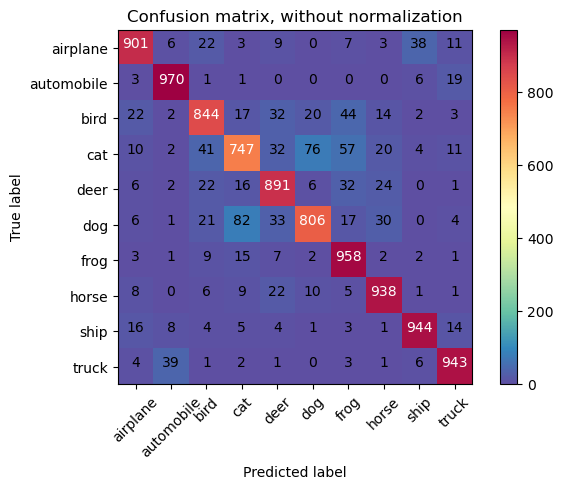

In [9]:
# load the pre-saved model
model_10 = load_model('model_10_VGG15_Base.h5')

# test the accuracy of the model on the test set
loss, accuracy = model_10.evaluate(x_test, y_test)

# print the accuracy of the model on the test set
print('model_10_VGG15_Base.h5 Test accuracy:', accuracy)

# Make predictions
y_pred = model_10.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [90]:
model_10 = Sequential()
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Dropout(0.1))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# define the ModelCheckpoint callback to save the model after each epoch
checkpoint_callback = ModelCheckpoint(filepath='model_10_VGG12_Base.h5', save_freq='epoch')

# compile model
opt = SGD(lr=0.001, momentum=0.9)
model_10.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train and evaluate the quantization aware model
model_10.fit(it_train, steps_per_epoch=steps, epochs=400,
                      validation_data=(x_test, y_test), callbacks=[checkpoint_callback])

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_979 (Conv2D)         (None, 32, 32, 16)        448       
                                                                 
 conv2d_980 (Conv2D)         (None, 32, 32, 16)        2320      
                                                                 
 dropout_475 (Dropout)       (None, 32, 32, 16)        0         
                                                                 
 conv2d_981 (Conv2D)         (None, 32, 32, 32)        4640      
                                                                 
 conv2d_982 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_364 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                     

/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


781/781 [==============================] - 15s 18ms/step - loss: 2.2575 - accuracy: 0.1561 - val_loss: 2.1627 - val_accuracy: 0.2199
Epoch 2/400
781/781 [==============================] - 16s 20ms/step - loss: 2.1116 - accuracy: 0.2004 - val_loss: 2.1177 - val_accuracy: 0.1918
Epoch 3/400
781/781 [==============================] - 14s 18ms/step - loss: 1.9997 - accuracy: 0.2169 - val_loss: 1.9502 - val_accuracy: 0.2357
Epoch 4/400
781/781 [==============================] - 15s 19ms/step - loss: 1.9246 - accuracy: 0.2488 - val_loss: 1.8245 - val_accuracy: 0.3032
Epoch 5/400
781/781 [==============================] - 14s 17ms/step - loss: 1.8442 - accuracy: 0.2858 - val_loss: 1.7600 - val_accuracy: 0.3309
Epoch 6/400
781/781 [==============================] - 14s 18ms/step - loss: 1.7766 - accuracy: 0.3172 - val_loss: 1.7120 - val_accuracy: 0.3573
Epoch 7/400
781/781 [==============================] - 14s 18ms/step - loss: 1.7247 - accuracy: 0.3400 - val_loss: 1.6124 - val_accuracy: 0.39

781/781 [==============================] - 14s 17ms/step - loss: 0.6509 - accuracy: 0.7802 - val_loss: 0.6296 - val_accuracy: 0.7896
Epoch 114/400
781/781 [==============================] - 14s 18ms/step - loss: 0.6446 - accuracy: 0.7814 - val_loss: 0.6106 - val_accuracy: 0.7998
Epoch 115/400
781/781 [==============================] - 15s 19ms/step - loss: 0.6482 - accuracy: 0.7824 - val_loss: 0.5767 - val_accuracy: 0.8038
Epoch 116/400
781/781 [==============================] - 14s 18ms/step - loss: 0.6404 - accuracy: 0.7826 - val_loss: 0.5765 - val_accuracy: 0.8065
Epoch 117/400
781/781 [==============================] - 14s 18ms/step - loss: 0.6431 - accuracy: 0.7811 - val_loss: 0.5887 - val_accuracy: 0.8031
Epoch 118/400
781/781 [==============================] - 14s 18ms/step - loss: 0.6354 - accuracy: 0.7834 - val_loss: 0.5592 - val_accuracy: 0.8114
Epoch 119/400
781/781 [==============================] - 14s 18ms/step - loss: 0.6381 - accuracy: 0.7839 - val_loss: 0.5960 - val_ac

Epoch 169/400
781/781 [==============================] - 15s 19ms/step - loss: 0.5299 - accuracy: 0.8226 - val_loss: 0.5335 - val_accuracy: 0.8255
Epoch 170/400
781/781 [==============================] - 15s 19ms/step - loss: 0.5347 - accuracy: 0.8206 - val_loss: 0.4954 - val_accuracy: 0.8376
Epoch 171/400
781/781 [==============================] - 14s 18ms/step - loss: 0.5354 - accuracy: 0.8191 - val_loss: 0.5363 - val_accuracy: 0.8215
Epoch 172/400
781/781 [==============================] - 14s 18ms/step - loss: 0.5304 - accuracy: 0.8232 - val_loss: 0.4851 - val_accuracy: 0.8419
Epoch 173/400
781/781 [==============================] - 15s 19ms/step - loss: 0.5318 - accuracy: 0.8217 - val_loss: 0.5157 - val_accuracy: 0.8272
Epoch 174/400
781/781 [==============================] - 14s 18ms/step - loss: 0.5307 - accuracy: 0.8219 - val_loss: 0.4968 - val_accuracy: 0.8375
Epoch 175/400
781/781 [==============================] - 14s 18ms/step - loss: 0.5305 - accuracy: 0.8212 - val_loss: 0

Epoch 225/400
781/781 [==============================] - 15s 19ms/step - loss: 0.4668 - accuracy: 0.8439 - val_loss: 0.4966 - val_accuracy: 0.8421
Epoch 226/400
781/781 [==============================] - 15s 19ms/step - loss: 0.4647 - accuracy: 0.8441 - val_loss: 0.4472 - val_accuracy: 0.8543
Epoch 227/400
781/781 [==============================] - 14s 18ms/step - loss: 0.4635 - accuracy: 0.8440 - val_loss: 0.4680 - val_accuracy: 0.8484
Epoch 228/400
781/781 [==============================] - 14s 17ms/step - loss: 0.4619 - accuracy: 0.8458 - val_loss: 0.5228 - val_accuracy: 0.8337
Epoch 229/400
781/781 [==============================] - 14s 18ms/step - loss: 0.4615 - accuracy: 0.8445 - val_loss: 0.4695 - val_accuracy: 0.8486
Epoch 230/400
781/781 [==============================] - 14s 18ms/step - loss: 0.4634 - accuracy: 0.8439 - val_loss: 0.4731 - val_accuracy: 0.8472
Epoch 231/400
781/781 [==============================] - 14s 18ms/step - loss: 0.4606 - accuracy: 0.8457 - val_loss: 0

Epoch 281/400
781/781 [==============================] - 15s 20ms/step - loss: 0.4170 - accuracy: 0.8598 - val_loss: 0.4477 - val_accuracy: 0.8587
Epoch 282/400
781/781 [==============================] - 15s 19ms/step - loss: 0.4205 - accuracy: 0.8585 - val_loss: 0.4495 - val_accuracy: 0.8575
Epoch 283/400
781/781 [==============================] - 15s 19ms/step - loss: 0.4216 - accuracy: 0.8582 - val_loss: 0.4509 - val_accuracy: 0.8560
Epoch 284/400
781/781 [==============================] - 15s 20ms/step - loss: 0.4202 - accuracy: 0.8595 - val_loss: 0.4550 - val_accuracy: 0.8530
Epoch 285/400
781/781 [==============================] - 15s 19ms/step - loss: 0.4177 - accuracy: 0.8587 - val_loss: 0.4109 - val_accuracy: 0.8679
Epoch 286/400
781/781 [==============================] - 15s 19ms/step - loss: 0.4157 - accuracy: 0.8612 - val_loss: 0.4208 - val_accuracy: 0.8639
Epoch 287/400
781/781 [==============================] - 15s 20ms/step - loss: 0.4090 - accuracy: 0.8630 - val_loss: 0

Epoch 337/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3830 - accuracy: 0.8704 - val_loss: 0.4074 - val_accuracy: 0.8707
Epoch 338/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3800 - accuracy: 0.8734 - val_loss: 0.4016 - val_accuracy: 0.8748
Epoch 339/400
781/781 [==============================] - 15s 19ms/step - loss: 0.3794 - accuracy: 0.8721 - val_loss: 0.4265 - val_accuracy: 0.8662
Epoch 340/400
781/781 [==============================] - 15s 19ms/step - loss: 0.3794 - accuracy: 0.8714 - val_loss: 0.4161 - val_accuracy: 0.8687
Epoch 341/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3804 - accuracy: 0.8728 - val_loss: 0.4159 - val_accuracy: 0.8662
Epoch 342/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3836 - accuracy: 0.8720 - val_loss: 0.4306 - val_accuracy: 0.8639
Epoch 343/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3798 - accuracy: 0.8719 - val_loss: 0

Epoch 393/400
321/781 [===========>..................] - ETA: 7s - loss: 0.3556 - accuracy: 0.8773

313/313 [==============================] - 1s 3ms/step - loss: 0.4116 - accuracy: 0.8717
model_10_VGG12_Base.h5 Test accuracy: 0.8716999888420105
313/313 [==============================] - 1s 2ms/step
Confusion matrix, without normalization
[[890   9  22  14   9   0  11   9  20  16]
 [  2 956   1   1   0   0   3   0   5  32]
 [ 30   1 791  18  34  23  78  18   3   4]
 [  7   4  32 714  35  86  89  25   2   6]
 [  4   1  24  17 862   6  54  31   1   0]
 [  4   3  22 102  30 767  43  28   1   0]
 [  3   0  12   9   4   3 962   3   2   2]
 [  3   0  10  14  25   7  14 922   2   3]
 [ 38  13   4   4   2   0  11   2 911  15]
 [  8  34   3   1   1   0   4   0   7 942]]


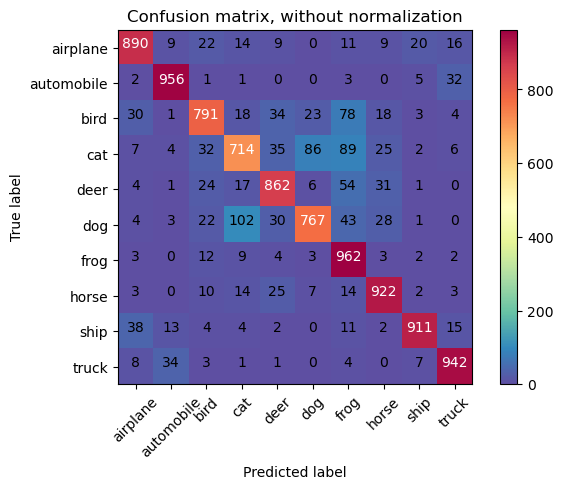

In [10]:
# load the pre-saved model
model_10 = load_model('model_10_VGG12_Base.h5')

# test the accuracy of the model on the test set
loss, accuracy = model_10.evaluate(x_test, y_test)

# print the accuracy of the model on the test set
print('model_10_VGG12_Base.h5 Test accuracy:', accuracy)

# Make predictions
y_pred = model_10.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [14]:
model_10 = Sequential()
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Dropout(0.1))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model_10)

# compile model
opt = SGD(lr=0.001, momentum=0.9)
quant_aware_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath='model_10_VGG15_Base_QAT.h5', save_freq='epoch')

quant_aware_model.summary()

# Train and evaluate the quantization aware model
quant_aware_model.fit(x_train, y_train, steps_per_epoch=steps,epochs=400,
                      callbacks=[checkpoint_callback],validation_data=(x_test, y_test))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_3 (QuantizeL  (None, 32, 32, 3)        3         
 ayer)                                                           
                                                                 
 quant_conv2d_39 (QuantizeWr  (None, 32, 32, 16)       483       
 apperV2)                                                        
                                                                 
 quant_conv2d_40 (QuantizeWr  (None, 32, 32, 16)       2355      
 apperV2)                                                        
                                                                 
 quant_dropout_18 (QuantizeW  (None, 32, 32, 16)       1         
 rapperV2)                                                       
                                                                 
 quant_conv2d_41 (QuantizeWr  (None, 32, 32, 32)      

781/781 [==============================] - 26s 33ms/step - loss: 1.2207 - accuracy: 0.5644 - val_loss: 1.1107 - val_accuracy: 0.6007
Epoch 18/400
781/781 [==============================] - 26s 33ms/step - loss: 1.1909 - accuracy: 0.5729 - val_loss: 1.0687 - val_accuracy: 0.6157
Epoch 19/400
781/781 [==============================] - 26s 33ms/step - loss: 1.1608 - accuracy: 0.5848 - val_loss: 1.0515 - val_accuracy: 0.6168
Epoch 20/400
781/781 [==============================] - 26s 33ms/step - loss: 1.1342 - accuracy: 0.5946 - val_loss: 0.9909 - val_accuracy: 0.6454
Epoch 21/400
781/781 [==============================] - 26s 33ms/step - loss: 1.0986 - accuracy: 0.6101 - val_loss: 1.0336 - val_accuracy: 0.6296
Epoch 22/400
781/781 [==============================] - 26s 33ms/step - loss: 1.0869 - accuracy: 0.6136 - val_loss: 0.9739 - val_accuracy: 0.6499
Epoch 23/400
781/781 [==============================] - 26s 33ms/step - loss: 1.0560 - accuracy: 0.6266 - val_loss: 0.9347 - val_accuracy

781/781 [==============================] - 26s 33ms/step - loss: 0.5464 - accuracy: 0.8153 - val_loss: 0.5961 - val_accuracy: 0.8037
Epoch 74/400
781/781 [==============================] - 26s 33ms/step - loss: 0.5349 - accuracy: 0.8183 - val_loss: 0.6021 - val_accuracy: 0.8024
Epoch 75/400
781/781 [==============================] - 26s 33ms/step - loss: 0.5272 - accuracy: 0.8204 - val_loss: 0.6054 - val_accuracy: 0.8082
Epoch 76/400
781/781 [==============================] - 26s 33ms/step - loss: 0.5285 - accuracy: 0.8209 - val_loss: 0.6092 - val_accuracy: 0.8028
Epoch 77/400
781/781 [==============================] - 26s 33ms/step - loss: 0.5206 - accuracy: 0.8229 - val_loss: 0.5813 - val_accuracy: 0.8128
Epoch 78/400
781/781 [==============================] - 26s 33ms/step - loss: 0.5185 - accuracy: 0.8247 - val_loss: 0.5861 - val_accuracy: 0.8040
Epoch 79/400
781/781 [==============================] - 26s 33ms/step - loss: 0.5037 - accuracy: 0.8285 - val_loss: 0.5826 - val_accuracy

781/781 [==============================] - 26s 33ms/step - loss: 0.3399 - accuracy: 0.8848 - val_loss: 0.5425 - val_accuracy: 0.8438
Epoch 130/400
781/781 [==============================] - 26s 33ms/step - loss: 0.3350 - accuracy: 0.8854 - val_loss: 0.5527 - val_accuracy: 0.8381
Epoch 131/400
781/781 [==============================] - 26s 33ms/step - loss: 0.3320 - accuracy: 0.8878 - val_loss: 0.5671 - val_accuracy: 0.8361
Epoch 132/400
781/781 [==============================] - 26s 33ms/step - loss: 0.3308 - accuracy: 0.8873 - val_loss: 0.5543 - val_accuracy: 0.8412
Epoch 133/400
781/781 [==============================] - 26s 33ms/step - loss: 0.3315 - accuracy: 0.8862 - val_loss: 0.5529 - val_accuracy: 0.8366
Epoch 134/400
781/781 [==============================] - 26s 33ms/step - loss: 0.3345 - accuracy: 0.8875 - val_loss: 0.5687 - val_accuracy: 0.8396
Epoch 135/400
781/781 [==============================] - 26s 33ms/step - loss: 0.3244 - accuracy: 0.8878 - val_loss: 0.5281 - val_ac

Epoch 185/400
781/781 [==============================] - 26s 33ms/step - loss: 0.2358 - accuracy: 0.9210 - val_loss: 0.5680 - val_accuracy: 0.8492
Epoch 186/400
781/781 [==============================] - 26s 33ms/step - loss: 0.2362 - accuracy: 0.9186 - val_loss: 0.5777 - val_accuracy: 0.8457
Epoch 187/400
781/781 [==============================] - 26s 33ms/step - loss: 0.2271 - accuracy: 0.9224 - val_loss: 0.5766 - val_accuracy: 0.8490
Epoch 188/400
781/781 [==============================] - 26s 33ms/step - loss: 0.2377 - accuracy: 0.9185 - val_loss: 0.5645 - val_accuracy: 0.8510
Epoch 189/400
781/781 [==============================] - 26s 33ms/step - loss: 0.2241 - accuracy: 0.9231 - val_loss: 0.5434 - val_accuracy: 0.8505
Epoch 190/400
781/781 [==============================] - 26s 33ms/step - loss: 0.2230 - accuracy: 0.9251 - val_loss: 0.5573 - val_accuracy: 0.8505
Epoch 191/400
781/781 [==============================] - 26s 33ms/step - loss: 0.2263 - accuracy: 0.9227 - val_loss: 0

Epoch 241/400
781/781 [==============================] - 26s 33ms/step - loss: 0.1676 - accuracy: 0.9439 - val_loss: 0.5945 - val_accuracy: 0.8509
Epoch 242/400
781/781 [==============================] - 26s 33ms/step - loss: 0.1695 - accuracy: 0.9431 - val_loss: 0.6204 - val_accuracy: 0.8548
Epoch 243/400
781/781 [==============================] - 26s 33ms/step - loss: 0.1654 - accuracy: 0.9428 - val_loss: 0.6154 - val_accuracy: 0.8527
Epoch 244/400
781/781 [==============================] - 26s 33ms/step - loss: 0.1703 - accuracy: 0.9427 - val_loss: 0.6385 - val_accuracy: 0.8489
Epoch 245/400
781/781 [==============================] - 26s 33ms/step - loss: 0.1677 - accuracy: 0.9422 - val_loss: 0.5919 - val_accuracy: 0.8524
Epoch 246/400
781/781 [==============================] - 26s 33ms/step - loss: 0.1664 - accuracy: 0.9426 - val_loss: 0.5855 - val_accuracy: 0.8523
Epoch 247/400
781/781 [==============================] - 26s 33ms/step - loss: 0.1638 - accuracy: 0.9462 - val_loss: 0

Epoch 297/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1326 - accuracy: 0.9555 - val_loss: 0.6475 - val_accuracy: 0.8550
Epoch 298/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1295 - accuracy: 0.9562 - val_loss: 0.6539 - val_accuracy: 0.8576
Epoch 299/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1286 - accuracy: 0.9578 - val_loss: 0.6474 - val_accuracy: 0.8523
Epoch 300/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1309 - accuracy: 0.9555 - val_loss: 0.6381 - val_accuracy: 0.8521
Epoch 301/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1295 - accuracy: 0.9570 - val_loss: 0.6904 - val_accuracy: 0.8484
Epoch 302/400
781/781 [==============================] - 26s 33ms/step - loss: 0.1278 - accuracy: 0.9565 - val_loss: 0.6384 - val_accuracy: 0.8542
Epoch 303/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1279 - accuracy: 0.9571 - val_loss: 0

Epoch 353/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1039 - accuracy: 0.9652 - val_loss: 0.6995 - val_accuracy: 0.8567
Epoch 354/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1049 - accuracy: 0.9643 - val_loss: 0.6771 - val_accuracy: 0.8586
Epoch 355/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1028 - accuracy: 0.9645 - val_loss: 0.6632 - val_accuracy: 0.8597
Epoch 356/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1007 - accuracy: 0.9658 - val_loss: 0.6861 - val_accuracy: 0.8568
Epoch 357/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1004 - accuracy: 0.9663 - val_loss: 0.6824 - val_accuracy: 0.8592
Epoch 358/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1005 - accuracy: 0.9653 - val_loss: 0.7147 - val_accuracy: 0.8572
Epoch 359/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1046 - accuracy: 0.9651 - val_loss: 0

781/781 [==============================] - 11s 14ms/step - loss: 0.0924 - accuracy: 0.9697 - val_loss: 0.7115 - val_accuracy: 0.8584


In [15]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(x_test, y_test, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

open("model_10_VGG15_Base_QAT.tflite", "wb").write(tflite_model_quant_int8_qat)

Quantization aware training loss:  0.7115015387535095
Quantization aware training accuracy:  0.8583999872207642


INFO:tensorflow:Assets written to: /tmp/tmp9xh8m6xe/assets


INFO:tensorflow:Assets written to: /tmp/tmp9xh8m6xe/assets
/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-06 03:08:47.932738: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-06 03:08:47.932769: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-06 03:08:47.932915: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9xh8m6xe
2023-06-06 03:08:47.941886: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-06 03:08:47.941905: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9xh8m6xe
2023-06-06 03:08:47.981603: I tensorflow/

1030152

In [16]:
c_model_name = 'cifar10_vgg15_base_qat'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

== Input details ==
name: serving_default_conv2d_39_input:0
shape: [ 1 32 32  3]
type: <class 'numpy.uint8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.uint8'>
Accuracy of model_10_VGG15_Base_QAT.tflite is 85.79%
Confusion matrix, without normalization
[[869   6  32   7  10   1   7  11  38  19]
 [  4 944   3   1   1   2   7   0   7  31]
 [ 42   1 823  16  42  21  38   7   9   1]
 [ 14   3  64 666  39 118  60  23   6   7]
 [  6   0  40  26 864  15  23  21   4   1]
 [  7   0  40  98  28 787  12  23   2   3]
 [  5   0  27  19  20   6 915   4   3   1]
 [  8   1  17  22  35  26   5 879   2   5]
 [ 32  10   4   7   2   1   6   0 927  11]
 [ 12  55   3   3   0   1   8   0  13 905]]


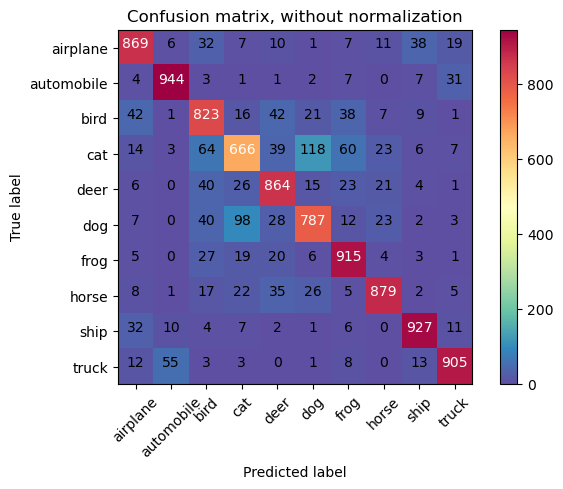

In [17]:
tflite_interpreter = tf.lite.Interpreter("model_10_VGG15_Base_QAT.tflite")
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

predictions = np.zeros((len(x_test),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(x_test)):
    val_batch = x_test[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
    
sum = 0
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
accuracy_score = sum / 10000
print("Accuracy of model_10_VGG15_Base_QAT.tflite is {}%".format(accuracy_score*100))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [18]:
model_10 = Sequential()
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Dropout(0.1))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model_10)

# compile model
opt = SGD(lr=0.001, momentum=0.9)
quant_aware_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath='model_10_VGG12_Base_QAT.h5', save_freq='epoch')

quant_aware_model.summary()

# Train and evaluate the quantization aware model
quant_aware_model.fit(x_train, y_train, steps_per_epoch=steps,epochs=200,
                      callbacks=[checkpoint_callback],validation_data=(x_test, y_test))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 conv2d_53 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 dropout_24 (Dropout)        (None, 32, 32, 16)        0         
                                                                 
 conv2d_54 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 conv2d_55 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                      

                                                                 
 quant_dropout_29 (QuantizeW  (None, 128)              1         
 rapperV2)                                                       
                                                                 
 quant_dense_9 (QuantizeWrap  (None, 10)               1295      
 perV2)                                                          
                                                                 
Total params: 657,168
Trainable params: 655,642
Non-trainable params: 1,526
_________________________________________________________________


/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
781/781 [==============================] - 21s 25ms/step - loss: 2.3043 - accuracy: 0.1252 - val_loss: 2.2146 - val_accuracy: 0.2022
Epoch 2/200
781/781 [==============================] - 20s 25ms/step - loss: 2.1503 - accuracy: 0.1952 - val_loss: 2.0920 - val_accuracy: 0.2341
Epoch 3/200
781/781 [==============================] - 19s 25ms/step - loss: 2.0300 - accuracy: 0.2213 - val_loss: 2.0267 - val_accuracy: 0.2298
Epoch 4/200
781/781 [==============================] - 20s 25ms/step - loss: 1.8813 - accuracy: 0.2692 - val_loss: 1.8381 - val_accuracy: 0.2966
Epoch 5/200
781/781 [==============================] - 20s 25ms/step - loss: 1.7871 - accuracy: 0.3052 - val_loss: 1.7669 - val_accuracy: 0.3182
Epoch 6/200
781/781 [==============================] - 20s 25ms/step - loss: 1.7187 - accuracy: 0.3330 - val_loss: 1.6068 - val_accuracy: 0.3890
Epoch 7/200
781/781 [==============================] - 20s 25ms/step - loss: 1.6683 - accuracy: 0.3542 - val_loss: 1.6628 - val_ac

781/781 [==============================] - 20s 25ms/step - loss: 0.7570 - accuracy: 0.7373 - val_loss: 0.6988 - val_accuracy: 0.7598
Epoch 58/200
781/781 [==============================] - 20s 25ms/step - loss: 0.7599 - accuracy: 0.7385 - val_loss: 0.7122 - val_accuracy: 0.7578
Epoch 59/200
781/781 [==============================] - 19s 25ms/step - loss: 0.7540 - accuracy: 0.7390 - val_loss: 0.7002 - val_accuracy: 0.7646
Epoch 60/200
781/781 [==============================] - 19s 25ms/step - loss: 0.7400 - accuracy: 0.7435 - val_loss: 0.6740 - val_accuracy: 0.7647
Epoch 61/200
781/781 [==============================] - 19s 25ms/step - loss: 0.7386 - accuracy: 0.7455 - val_loss: 0.6786 - val_accuracy: 0.7655
Epoch 62/200
781/781 [==============================] - 19s 25ms/step - loss: 0.7278 - accuracy: 0.7474 - val_loss: 0.6672 - val_accuracy: 0.7725
Epoch 63/200
781/781 [==============================] - 19s 25ms/step - loss: 0.7126 - accuracy: 0.7546 - val_loss: 0.6752 - val_accuracy

781/781 [==============================] - 19s 25ms/step - loss: 0.4909 - accuracy: 0.8318 - val_loss: 0.5315 - val_accuracy: 0.8264
Epoch 114/200
781/781 [==============================] - 19s 25ms/step - loss: 0.4925 - accuracy: 0.8323 - val_loss: 0.5318 - val_accuracy: 0.8268
Epoch 115/200
781/781 [==============================] - 20s 25ms/step - loss: 0.4878 - accuracy: 0.8334 - val_loss: 0.5352 - val_accuracy: 0.8263
Epoch 116/200
781/781 [==============================] - 20s 25ms/step - loss: 0.4842 - accuracy: 0.8351 - val_loss: 0.5845 - val_accuracy: 0.8141
Epoch 117/200
781/781 [==============================] - 20s 25ms/step - loss: 0.4813 - accuracy: 0.8355 - val_loss: 0.5224 - val_accuracy: 0.8263
Epoch 118/200
781/781 [==============================] - 20s 25ms/step - loss: 0.4805 - accuracy: 0.8365 - val_loss: 0.5488 - val_accuracy: 0.8268
Epoch 119/200
781/781 [==============================] - 19s 25ms/step - loss: 0.4856 - accuracy: 0.8331 - val_loss: 0.5350 - val_ac

Epoch 169/200
781/781 [==============================] - 19s 25ms/step - loss: 0.3719 - accuracy: 0.8738 - val_loss: 0.4995 - val_accuracy: 0.8455
Epoch 170/200
781/781 [==============================] - 19s 25ms/step - loss: 0.3707 - accuracy: 0.8729 - val_loss: 0.5032 - val_accuracy: 0.8460
Epoch 171/200
781/781 [==============================] - 19s 25ms/step - loss: 0.3730 - accuracy: 0.8723 - val_loss: 0.4967 - val_accuracy: 0.8458
Epoch 172/200
781/781 [==============================] - 19s 25ms/step - loss: 0.3650 - accuracy: 0.8745 - val_loss: 0.4986 - val_accuracy: 0.8473
Epoch 173/200
781/781 [==============================] - 19s 25ms/step - loss: 0.3662 - accuracy: 0.8748 - val_loss: 0.5112 - val_accuracy: 0.8412
Epoch 174/200
781/781 [==============================] - 20s 25ms/step - loss: 0.3700 - accuracy: 0.8725 - val_loss: 0.5016 - val_accuracy: 0.8476
Epoch 175/200
781/781 [==============================] - 19s 25ms/step - loss: 0.3643 - accuracy: 0.8769 - val_loss: 0

781/781 [==============================] - 5s 7ms/step - loss: 0.3319 - accuracy: 0.8858 - val_loss: 0.4980 - val_accuracy: 0.8513


In [19]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(x_test, y_test, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

open("model_10_VGG12_Base_QAT.tflite", "wb").write(tflite_model_quant_int8_qat)

Quantization aware training loss:  0.49800658226013184
Quantization aware training accuracy:  0.8513000011444092


INFO:tensorflow:Assets written to: /tmp/tmpo2mziuqo/assets


INFO:tensorflow:Assets written to: /tmp/tmpo2mziuqo/assets
/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-06 04:54:05.148512: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-06 04:54:05.148538: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-06 04:54:05.148685: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo2mziuqo
2023-06-06 04:54:05.156395: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-06 04:54:05.156413: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo2mziuqo
2023-06-06 04:54:05.180556: I tensorflow/

687232

In [20]:
c_model_name = 'cifar10_vgg12_base_qat'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

== Input details ==
name: serving_default_conv2d_52_input:0
shape: [ 1 32 32  3]
type: <class 'numpy.uint8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.uint8'>
Accuracy of model_10_VGG12_Base_QAT.tflite is 85.26%
Confusion matrix, without normalization
[[854  15  21  14  10   1   9   2  47  27]
 [  4 936   0   2   0   1   2   0  10  45]
 [ 42   1 759  35  55  30  63   7   6   2]
 [ 10   4  31 710  44  98  72  15   4  12]
 [  9   1  32  30 847  16  40  22   2   1]
 [  4   3  19 129  30 776  20  17   0   2]
 [  3   1  18  20  14   7 935   1   1   0]
 [ 10   2  15  34  29  25   6 874   1   4]
 [ 31  13   4  10   2   0   6   1 917  16]
 [  7  44   4   5   2   0   4   2  14 918]]


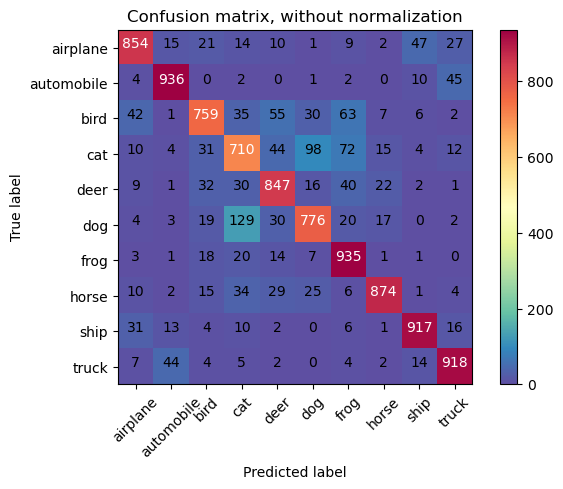

In [21]:
tflite_interpreter = tf.lite.Interpreter("model_10_VGG12_Base_QAT.tflite")
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

predictions = np.zeros((len(x_test),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(x_test)):
    val_batch = x_test[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
    
sum = 0
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
accuracy_score = sum / 10000
print("Accuracy of model_10_VGG12_Base_QAT.tflite is {}%".format(accuracy_score*100))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [26]:
model_10 = Sequential()
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model_10)

# compile model
opt = SGD(lr=0.001, momentum=0.9)
quant_aware_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath='model_10_VGG8_Base_QAT.h5', save_freq='epoch')

quant_aware_model.summary()

# Train and evaluate the quantization aware model
quant_aware_model.fit(x_train, y_train, steps_per_epoch=steps,epochs=200,
                      callbacks=[checkpoint_callback],validation_data=(x_test, y_test))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_86 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_87 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_46 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_88 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_89 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

781/781 [==============================] - 13s 17ms/step - loss: 1.2485 - accuracy: 0.5495 - val_loss: 1.1021 - val_accuracy: 0.6092
Epoch 13/200
781/781 [==============================] - 13s 17ms/step - loss: 1.2092 - accuracy: 0.5645 - val_loss: 1.0756 - val_accuracy: 0.6127
Epoch 14/200
781/781 [==============================] - 13s 17ms/step - loss: 1.1886 - accuracy: 0.5734 - val_loss: 1.0767 - val_accuracy: 0.6134
Epoch 15/200
781/781 [==============================] - 13s 17ms/step - loss: 1.1531 - accuracy: 0.5855 - val_loss: 1.0137 - val_accuracy: 0.6409
Epoch 16/200
781/781 [==============================] - 13s 17ms/step - loss: 1.1320 - accuracy: 0.5945 - val_loss: 1.0552 - val_accuracy: 0.6211
Epoch 17/200
781/781 [==============================] - 13s 16ms/step - loss: 1.1022 - accuracy: 0.6051 - val_loss: 0.9695 - val_accuracy: 0.6551
Epoch 18/200
781/781 [==============================] - 13s 16ms/step - loss: 1.0926 - accuracy: 0.6102 - val_loss: 0.9809 - val_accuracy

781/781 [==============================] - 13s 17ms/step - loss: 0.6117 - accuracy: 0.7889 - val_loss: 0.5701 - val_accuracy: 0.8066
Epoch 69/200
781/781 [==============================] - 13s 17ms/step - loss: 0.6088 - accuracy: 0.7909 - val_loss: 0.5659 - val_accuracy: 0.8085
Epoch 70/200
781/781 [==============================] - 13s 17ms/step - loss: 0.6049 - accuracy: 0.7912 - val_loss: 0.5878 - val_accuracy: 0.7977
Epoch 71/200
781/781 [==============================] - 13s 17ms/step - loss: 0.5937 - accuracy: 0.7951 - val_loss: 0.5903 - val_accuracy: 0.7940
Epoch 72/200
781/781 [==============================] - 13s 17ms/step - loss: 0.5900 - accuracy: 0.7944 - val_loss: 0.5550 - val_accuracy: 0.8103
Epoch 73/200
781/781 [==============================] - 13s 17ms/step - loss: 0.5905 - accuracy: 0.7942 - val_loss: 0.5658 - val_accuracy: 0.8050
Epoch 74/200
781/781 [==============================] - 13s 17ms/step - loss: 0.5911 - accuracy: 0.7953 - val_loss: 0.5562 - val_accuracy

781/781 [==============================] - 13s 16ms/step - loss: 0.4301 - accuracy: 0.8470 - val_loss: 0.5067 - val_accuracy: 0.8329
Epoch 125/200
781/781 [==============================] - 13s 16ms/step - loss: 0.4327 - accuracy: 0.8493 - val_loss: 0.4826 - val_accuracy: 0.8397
Epoch 126/200
781/781 [==============================] - 13s 16ms/step - loss: 0.4284 - accuracy: 0.8497 - val_loss: 0.4861 - val_accuracy: 0.8400
Epoch 127/200
781/781 [==============================] - 13s 17ms/step - loss: 0.4235 - accuracy: 0.8514 - val_loss: 0.4865 - val_accuracy: 0.8400
Epoch 128/200
781/781 [==============================] - 13s 17ms/step - loss: 0.4233 - accuracy: 0.8526 - val_loss: 0.4906 - val_accuracy: 0.8377
Epoch 129/200
781/781 [==============================] - 13s 17ms/step - loss: 0.4243 - accuracy: 0.8503 - val_loss: 0.5143 - val_accuracy: 0.8345
Epoch 130/200
781/781 [==============================] - 13s 17ms/step - loss: 0.4175 - accuracy: 0.8535 - val_loss: 0.4885 - val_ac

Epoch 180/200
781/781 [==============================] - 13s 17ms/step - loss: 0.3337 - accuracy: 0.8810 - val_loss: 0.4827 - val_accuracy: 0.8519
Epoch 181/200
781/781 [==============================] - 13s 17ms/step - loss: 0.3357 - accuracy: 0.8815 - val_loss: 0.5077 - val_accuracy: 0.8418
Epoch 182/200
781/781 [==============================] - 13s 17ms/step - loss: 0.3371 - accuracy: 0.8811 - val_loss: 0.4673 - val_accuracy: 0.8567
Epoch 183/200
781/781 [==============================] - 13s 16ms/step - loss: 0.3261 - accuracy: 0.8860 - val_loss: 0.4783 - val_accuracy: 0.8526
Epoch 184/200
781/781 [==============================] - 13s 17ms/step - loss: 0.3291 - accuracy: 0.8820 - val_loss: 0.4683 - val_accuracy: 0.8546
Epoch 185/200
781/781 [==============================] - 13s 17ms/step - loss: 0.3290 - accuracy: 0.8842 - val_loss: 0.4733 - val_accuracy: 0.8541
Epoch 186/200
781/781 [==============================] - 13s 16ms/step - loss: 0.3281 - accuracy: 0.8844 - val_loss: 0

781/781 [==============================] - 4s 5ms/step - loss: 0.3136 - accuracy: 0.8877 - val_loss: 0.4779 - val_accuracy: 0.8529


In [27]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(x_test, y_test, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

open("model_10_VGG8_Base_QAT.tflite", "wb").write(tflite_model_quant_int8_qat)

Quantization aware training loss:  0.47787293791770935
Quantization aware training accuracy:  0.8529000282287598


INFO:tensorflow:Assets written to: /tmp/tmpxouj9c9j/assets


INFO:tensorflow:Assets written to: /tmp/tmpxouj9c9j/assets
/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-06 10:22:15.988369: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-06 10:22:15.988400: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-06 10:22:15.988549: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxouj9c9j
2023-06-06 10:22:15.995048: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-06 10:22:15.995073: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxouj9c9j
2023-06-06 10:22:16.015404: I tensorflow/

571288

In [28]:
c_model_name = 'cifar10_vgg8_base_qat'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

== Input details ==
name: serving_default_conv2d_86_input:0
shape: [ 1 32 32  3]
type: <class 'numpy.uint8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.uint8'>
Accuracy of model_10_VGG8_Base_QAT.tflite is 85.28999999999999%
Confusion matrix, without normalization
[[859  12  25  11   8   0   6   5  48  26]
 [  4 940   1   1   0   2   5   0  14  33]
 [ 48   0 782  35  43  40  39   7   5   1]
 [ 12   3  40 714  36 116  51  12  10   6]
 [  7   1  36  36 847  15  33  21   4   0]
 [  8   1  27 117  24 792  10  19   1   1]
 [  4   2  24  32  17  11 904   1   2   3]
 [  6   2   9  28  51  44   5 850   0   5]
 [ 32  14   1   8   2   1   4   1 927  10]
 [  7  47   2   6   0   0   3   3  18 914]]


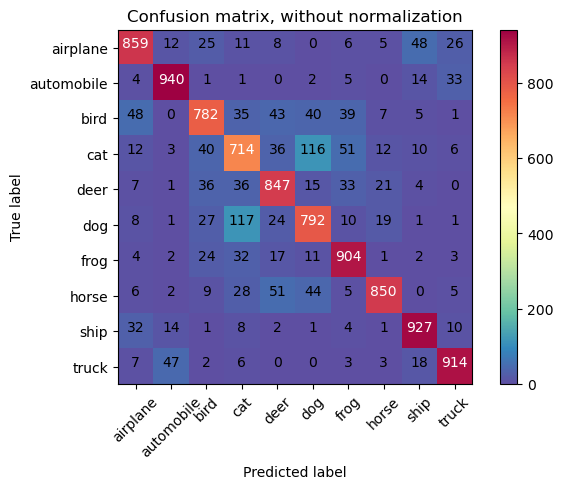

In [29]:
tflite_interpreter = tf.lite.Interpreter("model_10_VGG8_Base_QAT.tflite")
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

predictions = np.zeros((len(x_test),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(x_test)):
    val_batch = x_test[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
    
sum = 0
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
accuracy_score = sum / 10000
print("Accuracy of model_10_VGG8_Base_QAT.tflite is {}%".format(accuracy_score*100))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [ ]:
model_10 = Sequential()
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model_10)

# compile model
opt = SGD(lr=0.001, momentum=0.9)
quant_aware_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath='model_10_Reduced_A_QAT.h5', save_freq='epoch')

quant_aware_model.summary()

# Train and evaluate the quantization aware model
quant_aware_model.fit(x_train, y_train, steps_per_epoch=steps,epochs=200,
                      callbacks=[checkpoint_callback],validation_data=(x_test, y_test))

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_121 (Conv2D)         (None, 32, 32, 16)        448       
                                                                 
 conv2d_122 (Conv2D)         (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 dropout_68 (Dropout)        (None, 16, 16, 16)        0         
                                                                 
 conv2d_123 (Conv2D)         (None, 16, 16, 32)        4640      
                                                                 
 conv2d_124 (Conv2D)         (None, 16, 16, 32)        9248      
                                                     

/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
781/781 [==============================] - 16s 19ms/step - loss: 2.3014 - accuracy: 0.1320 - val_loss: 2.1712 - val_accuracy: 0.1913
Epoch 2/200
781/781 [==============================] - 14s 18ms/step - loss: 2.1093 - accuracy: 0.1869 - val_loss: 2.0376 - val_accuracy: 0.2104
Epoch 3/200
781/781 [==============================] - 14s 18ms/step - loss: 1.9787 - accuracy: 0.2083 - val_loss: 1.8900 - val_accuracy: 0.2541
Epoch 4/200
781/781 [==============================] - 14s 18ms/step - loss: 1.9137 - accuracy: 0.2362 - val_loss: 1.8391 - val_accuracy: 0.2938
Epoch 5/200
781/781 [==============================] - 14s 19ms/step - loss: 1.8368 - accuracy: 0.2808 - val_loss: 1.7272 - val_accuracy: 0.3472
Epoch 6/200
781/781 [==============================] - 14s 18ms/step - loss: 1.7661 - accuracy: 0.3152 - val_loss: 1.6639 - val_accuracy: 0.3638
Epoch 7/200
781/781 [==============================] - 15s 19ms/step - loss: 1.7217 - accuracy: 0.3356 - val_loss: 1.6342 - val_ac

In [ ]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(x_test, y_test, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

open("model_10_Reduced_A_QAT.tflite", "wb").write(tflite_model_quant_int8_qat)

In [ ]:
c_model_name = 'cifar10_reduced_a_qat'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

In [ ]:
tflite_interpreter = tf.lite.Interpreter("model_10_Reduced_A_QAT.tflite")
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

predictions = np.zeros((len(x_test),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(x_test)):
    val_batch = x_test[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
    
sum = 0
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
accuracy_score = sum / 10000
print("Accuracy of model_10_Reduced_A_QAT.tflite is {}%".format(accuracy_score*100))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())